# FullyConnected on MNIST (Accuracy, Implicit Model Calibration, Toy Knowledge Distillation)

### Imports and Setup

In [1]:
# PyTorch and Models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR
from architectures.FullyConnected import FullyConnected

# Helper functions
import datasets.datasets as datasets
from util.common import *
from util.trainer import distillation_training

In [2]:
# Make PyTorch deterministic
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load Data, Training and Test Sets

In [3]:
# Loading dataset into training and test data
training_loader = datasets.mnist_training_loader(True)
dist_training_loader = datasets.mnist_training_loader(False)
test_loader = datasets.mnist_test_loader()

100%|██████████| 9912422/9912422 [00:01<00:00, 6053508.94it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 54491990.02it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6464706.59it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 8512300.61it/s]


Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



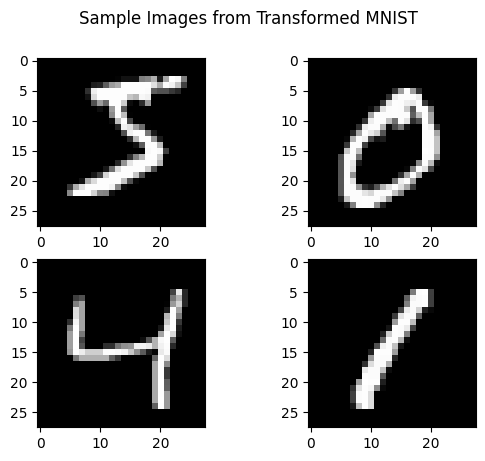

In [4]:
# Some sample images from the dataset
show_images (datasets.mnist_training_dataset(True), 4, 'Sample Images from Transformed MNIST')

### Distillation training loop

In [5]:
def train_distillation(teacher, student, device, training_loader, test_loader, epochs, beta, temperature=1):
    cross_entropy = nn.CrossEntropyLoss()
    loss = nn.MSELoss()
    train_loss = lambda outputs, labels, pred: (1-beta)*cross_entropy(outputs, labels) + beta*0.5*loss(pred,outputs)
    
    opt = optim.SGD(params=[
        {"params":student.linear1.parameters(), 'lr': 1},
        {"params":student.linear2.parameters(), 'lr': 1},
        {"params":student.linear3.parameters(), 'lr': 0.1}
        ], momentum=0.9, dampening=0.9)
    
    scheduler = LinearLR(opt, 1, 0, epochs)
    
    distillation_training(teacher, student, device, training_loader, test_loader, epochs, train_loss, opt, scheduler, temperature)

### Training with Distillation and Different Label Smoothing Constants

In [ ]:
model_Hard = FullyConnected(1200, 0)
model_Hard.train_model(device, training_loader, test_loader, 0, NUM_EPOCHS_FULLY_CONNECTED)

torch.save(model_Hard.state_dict(), "models/FC_MNIST_Accuracy_IMC/FullyConnected_MNIST_Hard_Labels.pt")

In [ ]:
model_teacher_Dropout = FullyConnected(1200)
model_teacher_Dropout.train_model(device, training_loader, test_loader, 0, NUM_EPOCHS_FULLY_CONNECTED)

torch.save(model_teacher_Dropout.state_dict(), "models/FC_MNIST_Toy_Distillation/FullyConnected_Teacher_Dropout.pt")

In [ ]:
model_student = FullyConnected(800, 0)
train_distillation(model_teacher_Dropout, model_student, device, dist_training_loader, test_loader, NUM_EPOCHS_FULLY_CONNECTED, 0.6)

torch.save(model_student.state_dict(), "models/FC_MNIST_Toy_Distillation/FullyConnected_Student_Dropout.pt")

In [ ]:
model_Smooth_1 = FullyConnected(1200, 0)
model_Smooth_1.train_model(device, training_loader, test_loader, 0.1, NUM_EPOCHS_FULLY_CONNECTED)

torch.save(model_Smooth_1.state_dict(), "models/FC_MNIST_Accuracy_IMC/FullyConnected_MNIST_Smooth_Labels_01.pt")
torch.save(model_Smooth_1.state_dict(), "models/FC_MNIST_Toy_Distillation/FullyConnected_Teacher_Smoothing.pt")

In [ ]:
model_student = FullyConnected(800, 0)
train_distillation(model_Smooth_1, model_student, device, dist_training_loader, test_loader, NUM_EPOCHS_FULLY_CONNECTED, 0.6)

torch.save(model_student.state_dict(), "models/FC_MNIST_Toy_Distillation/FullyConnected_Student_Smoothing.pt")

In [ ]:
model_Smooth_05 = FullyConnected(1200, 0)
model_Smooth_05.train_model(device, training_loader, test_loader, 0.05, NUM_EPOCHS_FULLY_CONNECTED)

torch.save(model_Smooth_05.state_dict(), "models/FC_MNIST_Accuracy_IMC/FullyConnected_MNIST_Smooth_Labels_005.pt")

In [ ]:
model_Smooth_15 = FullyConnected(1200, 0)
model_Smooth_15.train_model(device, training_loader, test_loader, 0.15, NUM_EPOCHS_FULLY_CONNECTED)

torch.save(model_Smooth_15.state_dict(), "models/FC_MNIST_Accuracy_IMC/FullyConnected_MNIST_Smooth_Labels_015.pt")

In [ ]:
model_Smooth_3 = FullyConnected(1200, 0)
model_Smooth_3.train_model(device, training_loader, test_loader, 0.3, NUM_EPOCHS_FULLY_CONNECTED)

torch.save(model_Smooth_3.state_dict(), "models/FC_MNIST_Accuracy_IMC/FullyConnected_MNIST_Smooth_Labels_03.pt")

### Errors and Reliabity

In [4]:
# Temperature for temperature scaling
temperature = 1.06

model = FullyConnected(1200, 0)
model.load_state_dict(torch.load(f"models/FC_MNIST_Accuracy_IMC/FullyConnected_MNIST_Hard_Labels.pt", map_location=device))
model.to(device)

# Compute Accuracy and Reliability
print(f"Error for teacher network not using Dropout: {100-compute_accuracy(model, test_loader, device).cpu().item():.2f}%")
rel_bins_Hard = bin_reliability(model, test_loader, device, NUM_BINS)
rel_bins_Temperature = bin_reliability(model, test_loader, device, NUM_BINS, temperature)

Error for teacher network not using Dropout: 0.94%


In [5]:
model = FullyConnected(1200)
model.load_state_dict(torch.load(f"models/FC_MNIST_Accuracy_IMC/FullyConnected_MNIST_Smooth_Labels_005.pt", map_location=device))
model.to(device)

# Compute Accuracy and Reliability
print(f"Error for teacher network using Label smoothing (alpha = 0.05): {100-compute_accuracy(model, test_loader, device).cpu().item():.2f}%")
rel_bins_Smooth = bin_reliability(model, test_loader, device, NUM_BINS)

Error for teacher network using Label smoothing (alpha = 0.05): 0.67%


In [6]:
model = FullyConnected(1200)
model.load_state_dict(torch.load(f"models/FC_MNIST_Accuracy_IMC/FullyConnected_MNIST_Smooth_Labels_01.pt", map_location=device))
model.to(device)

# Compute Accuracy and Reliability
print(f"Error for teacher network using Label smoothing (alpha = 0.1): {100-compute_accuracy(model, test_loader, device).cpu().item():.2f}%")
rel_bins_Smooth_2 = bin_reliability(model, test_loader, device, NUM_BINS)

Error for teacher network using Label smoothing (alpha = 0.1): 0.69%


In [7]:
model = FullyConnected(1200)
model.load_state_dict(torch.load(f"models/FC_MNIST_Accuracy_IMC/FullyConnected_MNIST_Smooth_Labels_015.pt", map_location=device))
model.to(device)

# Compute Accuracy and Reliability
print(f"Error for teacher network using Label smoothing (alpha = 0.15): {100-compute_accuracy(model, test_loader, device).cpu().item():.2f}%")
rel_bins_Smooth_3 = bin_reliability(model, test_loader, device, NUM_BINS)

Error for teacher network using Label smoothing (alpha = 0.15): 0.76%


In [8]:
model = FullyConnected(1200)
model.load_state_dict(torch.load(f"models/FC_MNIST_Accuracy_IMC/FullyConnected_MNIST_Smooth_Labels_03.pt", map_location=device))
model.to(device)

# Compute Accuracy and Reliability
print(f"Error for teacher network using Label smoothing (alpha = 0.3): {100-compute_accuracy(model, test_loader, device).cpu().item():.2f}%")
rel_bins_Smooth_4 = bin_reliability(model, test_loader, device, NUM_BINS)

Error for teacher network using Label smoothing (alpha = 0.3): 0.87%


#### Compute ECE Score

In [9]:
print(f"ECE w. Hard Labels: {calculate_ece(rel_bins_Hard):.4f}")
print(f"ECE w. Smooth Labels (alpha = 0.05): {calculate_ece(rel_bins_Smooth):.4f}")
print(f"ECE w. Smooth Labels (alpha = 0.1): {calculate_ece(rel_bins_Smooth_2):.4f}")
print(f"ECE w. Smooth Labels (alpha = 0.15): {calculate_ece(rel_bins_Smooth_3):.4f}")
print(f"ECE w. Smooth Labels (alpha = 0.3): {calculate_ece(rel_bins_Smooth_4):.4f}")
print(f"ECE w. Temperature Scaling: {calculate_ece(rel_bins_Temperature):.4f}")

ECE w. Hard Labels: 0.0020
ECE w. Smooth Labels (alpha = 0.05): 0.0557
ECE w. Smooth Labels (alpha = 0.1): 0.1020
ECE w. Smooth Labels (alpha = 0.15): 0.1467
ECE w. Smooth Labels (alpha = 0.3): 0.2809
ECE w. Temperature Scaling: 0.0013


#### Plot Reliability Diagram

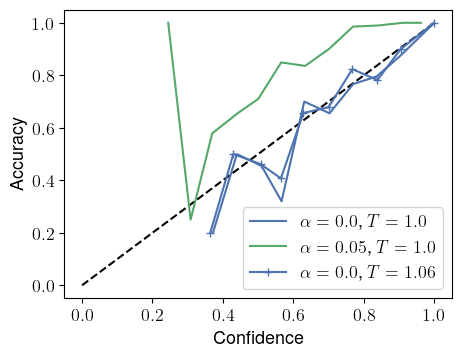

In [10]:
fig = plot_reliability(rel_bins_Hard, rel_bins_Smooth, rel_bins_Temperature, temperature, 0.05)
fig.savefig(format="pdf", fname="figures/reliability_mnist.pdf",bbox_inches='tight')

### Errors for the Toy Example

In [11]:
model = FullyConnected(1200)
model.load_state_dict(torch.load(f"models/FC_MNIST_Toy_Distillation/FullyConnected_Teacher_Dropout.pt", map_location=device))
model.to(device)

print(f"Error for teacher network using Dropout: {100-compute_accuracy(model, test_loader, device).cpu().item():.2f}%")

Error for teacher network using Dropout: 0.81%


In [12]:
model = FullyConnected(1200)
model.load_state_dict(torch.load(f"models/FC_MNIST_Toy_Distillation/FullyConnected_Teacher_Smoothing.pt", map_location=device))
model.to(device)

print(f"Error for teacher network using Label smoothing (alpha = 0.1): {100-compute_accuracy(model, test_loader, device).cpu().item():.2f}%")

Error for teacher network using Label smoothing (alpha = 0.1): 0.69%


In [13]:
model = FullyConnected(800)
model.load_state_dict(torch.load(f"models/FC_MNIST_Toy_Distillation/FullyConnected_Student_Dropout.pt", map_location=device))
model.to(device)

print(f"Error for student network with teacher network using Dropout: {100-compute_accuracy(model, test_loader, device).cpu().item():.2f}%")

Error for student network with teacher network using Dropout: 0.93%


In [14]:
model = FullyConnected(800)
model.load_state_dict(torch.load(f"models/FC_MNIST_Toy_Distillation/FullyConnected_Student_Smoothing.pt", map_location=device))
model.to(device)

print(f"Error for student network with teacher network using Label smoothing (alpha = 0.1): {100-compute_accuracy(model, test_loader, device).cpu().item():.2f}%")

Error for student network with teacher network using Label smoothing (alpha = 0.1): 1.05%
